In [1]:
from abc import ABCMeta, abstractmethod

from scipy.optimize import brute, optimize
from scipy.interpolate import interp2d
from scipy.stats import mode
import ROOT
import math
from typing import Callable

import numpy as np
# import jax.numpy as np
# import numpy as rnp
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


## Define fitting procedure

In [2]:
class PDF(metaclass=ABCMeta):
    name: str

    def __init__(self, name=None):
        self.name = name

    @abstractmethod
    def eval(self, energy, cos_angle):
        pass


class NumericPDF(PDF):
    """Pointing information about a particular type of interaction (such as electron scattering)."""
    name: str
    energy_min: float
    energy_max: float
    energy_bin_width: float

    cosAngle_min: float
    cosAngle_max: float
    cosAngle_bin_width: float

    interpolation: str | None
    pdf: np.ndarray
    pdf_linear: Callable
    pdf_cubic: Callable

    def __init__(self, name, energy_binning, cosAngle_binning, pdf, interpolation=None):
        super().__init__(name)
        (self.energy_min, self.energy_max, self.energy_bin_width) = energy_binning
        (self.cosAngle_min, self.cosAngle_max, self.cosAngle_bin_width) = cosAngle_binning
        self.pdf = pdf
        assert interpolation in (None, 'linear', 'cubic'), print("Interpolation modes are None, linear, cubic")
        self.interpolation = interpolation
        energy_coords = np.arange(0, len(pdf))
        cos_angle_coords = np.arange(0, len(pdf[0]))
        self.pdf_linear = interp2d(energy_coords, cos_angle_coords, np.transpose(pdf),
                                   bounds_error=False, fill_value=None, kind='linear')
        self.pdf_cubic = interp2d(energy_coords, cos_angle_coords, np.transpose(pdf),
                                  bounds_error=False, fill_value=None, kind='cubic')

    def eval(self, energy, cos_angle):
        if energy > self.energy_max:
            return 1.0
        energy_bin = (energy - self.energy_min) / self.energy_bin_width if energy > 0 else 0
        cos_angle_nbins = round((self.cosAngle_max - self.cosAngle_min) / self.cosAngle_bin_width)
        cos_angle_bin = (cos_angle - self.cosAngle_min) / self.cosAngle_bin_width
        cos_angle_bin = min(cos_angle_bin, cos_angle_nbins - 1)  # guard against cosAngle = 1
        if self.interpolation == 'linear':
            return self.pdf_linear(energy, cos_angle)
        elif self.interpolation == 'cubic':
            return self.pdf_cubic(energy, cos_angle)
        # no interpolation
        return self.pdf[int(energy_bin), int(cos_angle_bin)]


class ParametricPDF(PDF):
#     energy_min: float
#     energy_max: float
#     energy_bin_width: float
    energy_binning: np.ndarray
    params: np.ndarray

    def eval(self, energy, cos_angle):
#         if energy > self.energy_max:
#             return 1.0
        #energy_bin = int((energy - self.energy_min) / self.energy_bin_width) if energy > 0 else 0
        energy_bin = np.searchsorted(self.energy_binning, energy)
        (g_1, g_2, sigma_1, sigma_2, c) = self.params[energy_bin]
        return  g_1 * np.exp(- (cos_angle + 1) / sigma_1) + g_2 * np.exp((cos_angle - 1) / sigma_2) + c
        

    def __init__(self, name, energy_binning, params):
        super().__init__(name)
        # (self.energy_min, self.energy_max, self.energy_bin_width) = energy_binning
        self.energy_binning = np.asarray(energy_binning)
        self.params = params

In [3]:
def load_pdf_numeric(pdf_path, name=None):
    with open(pdf_path) as f:
        energy_binning = np.loadtxt(f, max_rows=1)
        cosAngle_binning = np.loadtxt(f, max_rows=1)
        pdf = np.loadtxt(f)
    # return energy_binning, cosAngle_binning, pdf
    return NumericPDF(name, energy_binning, cosAngle_binning, pdf)


def load_pdf_parameterized(pdf_path, name=None):
    with open(pdf_path) as f:
        energy_binning = np.loadtxt(f, max_rows=1)
        cosAngle_binning = np.loadtxt(f, max_rows=1)
        params = np.loadtxt(f)

    return ParametricPDF(name, energy_binning, params)

In [4]:
def charge_to_energy_clean(charge):
    m = 259.218
    b = 901.312
    return (charge - b) / m


def charge_to_energy_radio(charge):
    m = 248.111
    b = 2161.06
    return (charge - b) / m


def load_SN_file(filepath, with_radio=False):
    file = ROOT.TFile(filepath)
    tree = file.PointResTree.tr
    # nevts = tree.GetEntries()
    energies = []
    directions = []
    ievt = 0
    charge_to_energy = charge_to_energy_radio if with_radio else charge_to_energy_clean

    for event in tree:
        if event.NTrks == 0:
            continue
        energies.append(charge_to_energy(event.charge_corrected))

        directions.append([
            event.reco_e_dir.X(),
            event.reco_e_dir.Y(),
            event.reco_e_dir.Z()
        ])
        ievt += 1
    return np.asarray(energies), np.asarray(directions)


def get_truth_SN_dir(filepath):
    file = ROOT.TFile(filepath)
    tree = file.PointResTree.tr
    for event in tree:
        return np.array([event.truth_nu_dir.Theta(), event.truth_nu_dir.Phi()])


def sphere_to_xyz(direction):
    # [theta, phi] -> [x, y, z]
    return np.array([
        math.sin(direction[0]) * math.cos(direction[1]),
        math.sin(direction[0]) * math.sin(direction[1]),
        math.cos(direction[0])
    ])


def xyz_to_sphere(direction):
    # [x, y, z] => [theta, phi]
    # Identical to TVector3.Theta(), TVector3.Phi()
    direction_normalized = np.asarray(direction / np.linalg.norm(direction))
    phi = np.arctan2(direction_normalized[1], direction_normalized[0])
    perp = np.linalg.norm(direction_normalized[:2])
    theta = np.arctan2(perp, direction_normalized[2])
    return np.asarray([theta, phi])

In [5]:
class SupernovaPointing:
    """Class used to hold information about each supernova, and generate its loss function.
    """
    # Parallel list corresponding to each type of interaction
    PDFs: list[PDF]
    # tuple is [energy, direction]
    events_per_interaction: list[tuple[np.ndarray, np.ndarray]]
    weights: list[float]
    truth_dir: np.ndarray
    default_interpolation_type: str

    def __init__(self, PDFs, sn_event_files, weights=None, with_radio=False):

        """Class Constructor
        Args:
            @param PDFs: List of interaction information objects.
            @param sn_event_files: List of paths to ROOT files associated to each interaction.
            @param weights: Weight of each interaction. If None, they are all set to 1. Defaults to None.
        """
        self.PDFs = PDFs
        self.events_per_interaction = []
        for path in sn_event_files:
            self.events_per_interaction.append(load_SN_file(path, with_radio=with_radio))
        self.truth_dir = get_truth_SN_dir(sn_event_files[0])
        self.weights = [1.0] * len(self.events_per_interaction) if weights is None else weights

    def loss(self, sn_dir, weighting_factor=0, zero_bin=1e-4):
        """

        @param sn_dir: supernova direction, in form (theta, phi)
        @param weighting_factor: a linear weighting factor. Positive value biases higher energy bins. 0 means equal
        weighting.
        @param zero_bin: values to treat zero as (in preventing log(0)).
        @return: negative of log(likelihood)
        """
        sn_dir_xyz = sphere_to_xyz(sn_dir)
        loss = 0

        for pdf, events, weight in zip(self.PDFs, self.events_per_interaction, self.weights):
            interaction_loss = 0
            energies = events[0]
            cos_angles = events[1].dot(sn_dir_xyz)
            for energy, cos_angle in zip(energies, cos_angles):
                # # treat overly energetic events as having the same energy as PDF maxima
                if energy < 10:
                    continue
                pdf_value = pdf.eval(energy, cos_angle)
                # weighting formula is 1 + w * energy/100. Weight = 1 means 100MeV is doubly weighted
                pdf_value *= (1 + (energy/100) * weighting_factor)
                interaction_loss -= np.log(pdf_value)
            loss += interaction_loss * weight
        return loss
    
    def most_populated_dir(self, energy_cutoff=10):
        for events in self.events_per_interaction:
            directions = events[1][events[0]>energy_cutoff]
            width=0.05
            bins = np.floor(directions/width)
            # print(mode(bins).mode)
            dir_xyz = mode(bins).mode.flatten()*width
            return xyz_to_sphere(dir_xyz)
    
    def high_energy_event_direction(self, votes = 10):
        # Let the highest energy directions vote
        for events in self.events_per_interaction:
            idxs = np.argpartition(events[0], -votes)[-votes:]
            directions = []
            for idx in idxs:
                energy = events[0][idx]
                direction = events[1][idx]
                directions.append(direction)
            directions = np.asarray(directions)
            width = 0.25
            bins = np.floor(directions/width)
            dir_xyz = mode(bins).mode.flatten()*width
            return xyz_to_sphere(dir_xyz)
            

            

## Fitting Procedure

In [6]:
ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf.dat", name="ES")
directory = "/media/linux_store/hep/data/SN_radio/SN_ana_radiological/"

In [11]:
%%time
# Testing with a single file
import os

from scipy.optimize import brute, fmin
SN_pointer = SupernovaPointing([ES_numeric], [directory + "ES_PointResTree_29536379_100.root"], with_radio=True)
def loss_func(x):
    return SN_pointer.loss(x)
res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
print(res[0])
print(SN_pointer.truth_dir)
print(f"Loss = {loss_func(SN_pointer.truth_dir)}")

[ 2.37999443 -1.87226229]
[ 2.25607876 -1.8888417 ]
Loss = 450.198090143566
CPU times: user 80.8 ms, sys: 30.3 ms, total: 111 ms
Wall time: 1.39 s


ES Only: [0.856798   0.82506474]

7.133803748488294

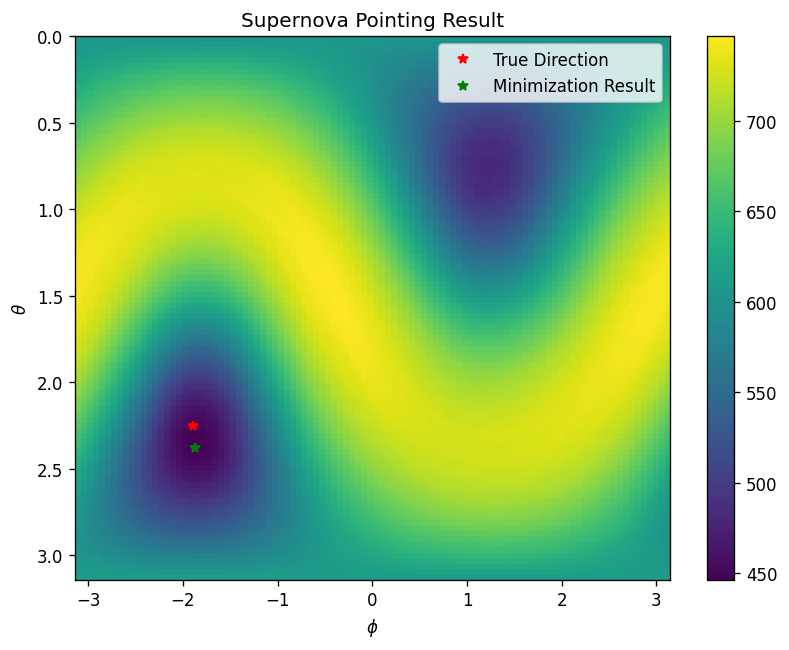

In [12]:
def error(pointer: SupernovaPointing, result, full_output = False, unit='deg'):
    assert unit in ['rad', 'deg'], "Unit must be deg or rad."
    if full_output:
        x0 = result[0]
    else:
        x0 = result
    
    angle = np.arccos(sphere_to_xyz(pointer.truth_dir).dot(sphere_to_xyz(x0)))
    return angle if unit=='rad' else angle*180/np.pi

def details(pointer: SupernovaPointing, result: tuple):
    # result [x0, fval, grid, jout]
    (x0, fval, grid, jout) = result
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(jout, extent=[-np.pi, np.pi, np.pi, 0], origin='upper', aspect='auto')
    plt.plot(pointer.truth_dir[1], pointer.truth_dir[0], 'r*', label="True Direction")
    plt.plot(x0[1], x0[0], 'g*', label='Minimization Result')
    plt.colorbar()
    plt.legend()
    plt.title('Supernova Pointing Result')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\theta$')
    dot = sphere_to_xyz(pointer.truth_dir).dot(sphere_to_xyz(x0))
    
    # return degree deviation between minimization and truth
    return np.arccos(dot)*180/np.pi

details(SN_pointer, res)
# error(SN_pointer, res)



In [15]:
%%time
# Testing with a single file

import os
from scipy.optimize import minimize
SN_pointer = SupernovaPointing([ES_param], [directory + "ES_PointResTree_29536379_100.root"], with_radio=True)
def loss_func(x):
    return SN_pointer.loss(x)
first = minimize(loss_func, np.array([np.pi/2, 0]))
second_direction_xyz = -1 * sphere_to_xyz(first.x)
second_direction_sphere = xyz_to_sphere(second_direction_xyz)
second = minimize(loss_func, second_direction_sphere)
final_dir = second.x if second.fun < first.fun else first.x

# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
print(final_dir)
print(SN_pointer.truth_dir)
# print(f"Loss = {loss_func(SN_pointer.truth_dir)}")

[ 2.33908424 -1.87995275]
[ 2.25607876 -1.8888417 ]
CPU times: user 144 ms, sys: 4.84 ms, total: 148 ms
Wall time: 138 ms


## Batch fitting

In [13]:
# Parse files


ES_files = os.listdir(directory)
SN_file_tuples = []
for ES_file in ES_files:
        SN_file_tuples.append([directory+ES_file])
        continue
    ## Corresponding CC File doesnt exist
    # print(f"Corresponding CC File not found for {ES_file}.")

print(f"Found {len(SN_file_tuples)} supernova files")

Found 853 supernova files


In [11]:
# Brute force grid search

errors = []
from tqdm import tqdm

for SN_file_tuple in tqdm(SN_file_tuples):
    SN_pointer = SupernovaPointing([ES_numeric], [SN_file_tuple[0]])
    # SN_pointer = SupernovaPointing([ES_param], [SN_file_tuple[0]])
    def loss_func(x):
        return SN_pointer.loss(x)
    res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                full_output=False, workers=6, finish=fmin)
    errors.append(error(SN_pointer, res))



  3%|▎         | 25/853 [00:05<03:09,  4.37it/s]Exception ignored in: <function _releaseLock at 0x7fc570e1e4d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
 16%|█▌        | 133/853 [00:30<03:02,  3.96it/s]

6.493769630965954

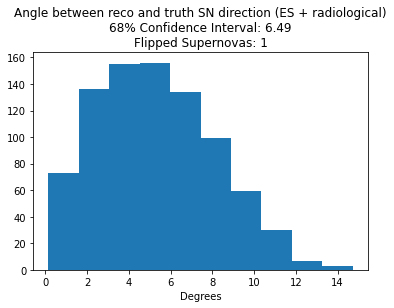

In [37]:
errors = np.asarray(errors)
plt.hist(errors[errors < 90])
plt.title(f"Angle between reco and truth SN direction (ES + radiological)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

100%|██████████| 853/853 [03:48<00:00,  3.73it/s]


NameError: name 'chisq' is not defined

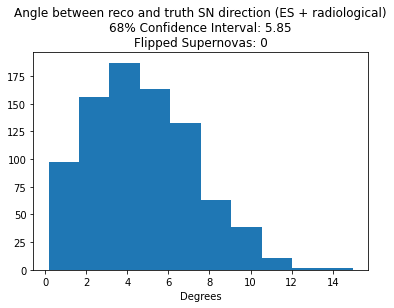

<Figure size 432x288 with 0 Axes>

In [16]:
# Do all the fits

errors = []
from tqdm import tqdm
dchisq = []
for SN_file_tuple in tqdm(SN_file_tuples):
    # SN_pointer = SupernovaPointing([ES_numeric], [SN_file_tuple[0]])
    SN_pointer = SupernovaPointing([ES_param], [SN_file_tuple[0]])
    def loss_func(x):
        return SN_pointer.loss(x)
    
#     res = minimize(loss_func, SN_pointer.high_energy_event_direction())
#     final_dir = res.x
    
    first = minimize(loss_func, np.array([np.pi/2, 0]))
    second_direction_xyz = -1 * sphere_to_xyz(first.x)
    second_direction_sphere = xyz_to_sphere(second_direction_xyz)
    second = minimize(loss_func, second_direction_sphere)
    dchisq.append(abs(second.fun - first.fun))
    final_dir = second.x if second.fun < first.fun else first.x
    errors.append(error(SN_pointer, final_dir))

plt.figure()
errors = np.asarray(errors)
plt.hist(errors)
plt.title(f"Angle between reco and truth SN direction (ES + radiological)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

plt.figure()
plt.hist(dchisq)
plt.title("$\Delta \chi^2$")


Text(0.5, 1.0, '$\\Delta \\chi^2$')

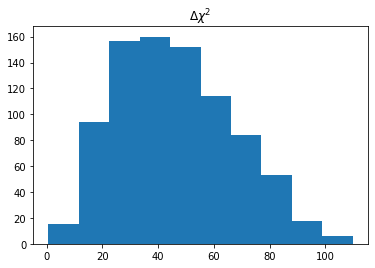

In [19]:
np.quantile(errors, 0.68)
plt.figure()
plt.hist(call_closeness)
plt.title("$\Delta \chi^2$")

Text(0, 0.5, '$\\cos(\\theta)$')

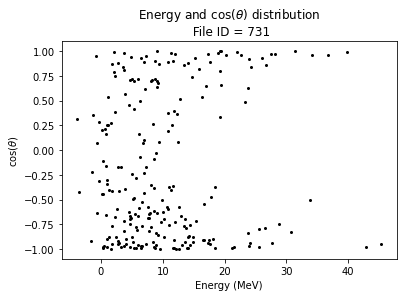

In [24]:
file_idx = 731
(energies, directions) = load_SN_file(SN_file_tuples[file_idx][0], with_radio=True)
truth_dir = sphere_to_xyz(get_truth_SN_dir(SN_file_tuples[file_idx][0]))
cosAngle = np.dot(directions, truth_dir)
plt.plot(energies, cosAngle, 'k.', markersize=4)
plt.title(f"Energy and $\cos(\\theta)$ distribution\n File ID = {file_idx}")
plt.xlabel("Energy (MeV)")
plt.ylabel(r"$\cos(\theta)$")

In [25]:
SN_pointer = SupernovaPointing([ES_param], [SN_file_tuples[file_idx][0]], with_radio=True)
def loss_func(x):
    return SN_pointer.loss(x)

res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
print(f"Loss at global minimum: {res[1]}")
print(f"Loss at true SN direction: {loss_func(SN_pointer.truth_dir)}")
print(f"Closeness: {res[1] - loss_func(SN_pointer.truth_dir)}")
details(SN_pointer, res)

## Use Minimization
# res = minimize(loss_func, x0=SN_pointer.high_energy_event_direction())
# print(res.x)
# print(SN_pointer.truth_dir)

Loss at global minimum: 398.14178395368924
Loss at true SN direction: 398.32614350915924
Closeness: -0.18435955546999594


NameError: name 'details' is not defined